In [1]:
%load_ext tensorboard

In [2]:
!pip install x-unet
!pip install scikit-learn
!pip install scikit-image

In [3]:
import random
import torch
import os

def set_seed(seed: int = 0):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed()

In [4]:
checkpoints_path = '/users/kolodny/gyanai/LF-MRI-Denoising/checkpoints'
os.makedirs(checkpoints_path, exist_ok=True)

In [5]:
import torch


def add_gaussian_noise(x: torch.Tensor, max_sigma: float, min_sigma: float = 0):
    sigmas = torch.rand(x.size(0), 1, 1, 1, device=x.device) * (max_sigma - min_sigma) + min_sigma
    noise = torch.randn_like(x) * sigmas
    return x + noise, sigmas

def add_rician_noise(img: torch.Tensor, max_sigma: float, min_sigma: float = 0) -> tuple[torch.Tensor, float]:
    """
    Add Rician noise to an image tensor.

    Args:
        img (torch.Tensor): Input image (float tensor).
        sigma (float): Standard deviation of the underlying Gaussian noise.

    Returns:
        torch.Tensor: Noisy image with Rician-distributed values.
    """
    sigma = torch.rand(1).item() * (max_sigma - min_sigma) + min_sigma
    # Generate Gaussian noise with mean=0, std=sigma
    n1 = torch.normal(mean=0.0, std=sigma, size=img.shape, device=img.device)
    n2 = torch.normal(mean=0.0, std=sigma, size=img.shape, device=img.device)

    # Apply Rician formula
    noisy_img = torch.sqrt((img + n1) ** 2 + n2 ** 2)

    return noisy_img, sigma

from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

def compute_psnr(clean_image: torch.Tensor, denoised_image: torch.Tensor):
    clean_image = clean_image.cpu().numpy()
    denoised_image = denoised_image.cpu().numpy()

    return psnr(clean_image, denoised_image, data_range=1.0)

def compute_ssim(clean_image: torch.Tensor, denoised_image: torch.Tensor):
    clean_image = clean_image.cpu().numpy()
    denoised_image = denoised_image.cpu().numpy()

    return ssim(clean_image, denoised_image, data_range=1.0)

In [6]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split
import numpy as np

class ImageOnlyDataset(torch.utils.data.Dataset):
    """Wrapper dataset that returns only images, ignoring labels"""
    def __init__(self, original_dataset):
        self.original_dataset = original_dataset

    def __len__(self):
        return len(self.original_dataset)

    def __getitem__(self, idx):
        image, _ = self.original_dataset[idx]  # Ignore label, return only image
        return image

from torch.utils.data import Subset

def load_mnist_method(limit=1000):
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    full_dataset = torchvision.datasets.MNIST(
        root='./data',
        train=True,
        download=True,
        transform=transform
    )
    full_dataset = ImageOnlyDataset(full_dataset)

    # Take only the first `limit` samples
    limited_dataset = Subset(full_dataset, range(limit))

    # Split into train/val (e.g., 80/20)
    train_size = int(0.8 * len(limited_dataset))
    val_size = len(limited_dataset) - train_size
    train_dataset, val_dataset = random_split(
        limited_dataset, [train_size, val_size],
        generator=torch.Generator().manual_seed(0)
    )

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

    # Test dataset – also limit if you want
    test_dataset = torchvision.datasets.MNIST(
        root='./data',
        train=False,
        download=True,
        transform=transform
    )
    test_dataset = ImageOnlyDataset(test_dataset)
    test_dataset = Subset(test_dataset, range(min(limit, len(test_dataset))))
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

    return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = load_mnist_method()

In [7]:
import torch
import torch.nn as nn
from x_unet import XUnet

# Create an instance of the XUnet model
unet = XUnet(
    dim=64,
    channels=1,
    dim_mults=(1, 2, 4, 8),
    nested_unet_depths=(6, 4, 2, 1),  # nested unet depths, from unet-squared paper
    consolidate_upsample_fmaps=True,  # whether to consolidate outputs from all upsample blocks, used in unet-squared paper
)

unet = nn.Sequential(unet, nn.Sigmoid())

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unet = unet.to(device)

In [9]:
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-4

# Define optimizer
opt = torch.optim.AdamW(unet.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

In [10]:
# K space

def fft2_image(x):
    # x: [B, C, H, W] torch tensor
    return torch.fft.fft2(x, norm='ortho')

def ifft2_image(k):
    # k: [B, C, H, W] complex tensor
    return torch.fft.ifft2(k, norm='ortho').real

def add_gaussian_noise_kspace(x: torch.Tensor, max_sigma: float, min_sigma: float = 0):
    """
    Add Gaussian noise in K-space to a batch of images.
    """
    kspace = fft2_image(x)
    # Create noise tensor of same shape
    sigmas = torch.rand(x.size(0), 1, 1, 1, device=x.device) * (max_sigma - min_sigma) + min_sigma
    noise = torch.randn_like(kspace) * sigmas
    noisy_kspace = kspace + noise
    x_noisy = ifft2_image(noisy_kspace)
    return x_noisy, sigmas


In [11]:
from tqdm import tqdm
import torch.nn.functional as F

NOISE_STD = 0.15
EPOCHS = 10
MODEL_OUT_DIR = os.path.join(checkpoints_path, 'vanilla')

os.makedirs(MODEL_OUT_DIR, exist_ok=True)


best_val = float("inf")

for epoch in range(1, EPOCHS + 1):
    unet.train()
    pbar = tqdm(iter(train_loader), desc=f"Epoch {epoch}/{EPOCHS}")

    train_loss = 0.0

    for x in pbar:
        x = x.to(device)          # clean target in [-1,1]
        x_noisy, _ = add_gaussian_noise_kspace(x, NOISE_STD)
        pred_noise = unet(x_noisy)          # predict clean image directly
        pred = x_noisy - pred_noise
        loss = F.l1_loss(pred, x)     # DAE loss
        loss.backward()
        opt.step()
        opt.zero_grad()

        train_loss += loss.item()

        pbar.set_postfix(loss=f"{loss.item():.4f}")

    train_loss /= len(train_loader)
    tqdm.write(f"Epoch {epoch} | train {train_loss:.4f}")

    # validation
    unet.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xv in iter(val_loader):
            xv = xv.to(device)
            xv_noisy, _ = add_gaussian_noise_kspace(xv, NOISE_STD)
            pred_noise = unet(xv_noisy)
            pred = xv_noisy - pred_noise
            val_loss += F.l1_loss(pred, xv).item()
    val_loss /= len(val_loader)

    # track best
    if val_loss < best_val:
        best_val = val_loss
        torch.save(unet.state_dict(), os.path.join(MODEL_OUT_DIR, "best_model.pt"))

    print(f"Epoch {epoch} | val {val_loss:.4f} | best {best_val:.4f}")

Epoch 1/10: 100%|██████████| 50/50 [01:01<00:00,  1.22s/it, loss=0.0386]


Epoch 1 | train 0.0541
Epoch 1 | val 0.0406 | best 0.0406


Epoch 2/10: 100%|██████████| 50/50 [00:59<00:00,  1.20s/it, loss=0.0434]


Epoch 2 | train 0.0416
Epoch 2 | val 0.0403 | best 0.0403


Epoch 3/10: 100%|██████████| 50/50 [01:00<00:00,  1.21s/it, loss=0.0381]


Epoch 3 | train 0.0423
Epoch 3 | val 0.0418 | best 0.0403


Epoch 4/10: 100%|██████████| 50/50 [01:00<00:00,  1.21s/it, loss=0.0322]


Epoch 4 | train 0.0431
Epoch 4 | val 0.0419 | best 0.0403


Epoch 5/10: 100%|██████████| 50/50 [01:00<00:00,  1.21s/it, loss=0.0418]


Epoch 5 | train 0.0433
Epoch 5 | val 0.0434 | best 0.0403


Epoch 6/10: 100%|██████████| 50/50 [01:00<00:00,  1.21s/it, loss=0.0417]


Epoch 6 | train 0.0429
Epoch 6 | val 0.0424 | best 0.0403


Epoch 7/10: 100%|██████████| 50/50 [01:00<00:00,  1.21s/it, loss=0.0290]


Epoch 7 | train 0.0415
Epoch 7 | val 0.0398 | best 0.0398


Epoch 8/10: 100%|██████████| 50/50 [01:00<00:00,  1.21s/it, loss=0.0433]


Epoch 8 | train 0.0421
Epoch 8 | val 0.0420 | best 0.0398


Epoch 9/10: 100%|██████████| 50/50 [01:00<00:00,  1.21s/it, loss=0.0507]


Epoch 9 | train 0.0423
Epoch 9 | val 0.0438 | best 0.0398


Epoch 10/10: 100%|██████████| 50/50 [01:00<00:00,  1.21s/it, loss=0.0443]


Epoch 10 | train 0.0417
Epoch 10 | val 0.0400 | best 0.0398


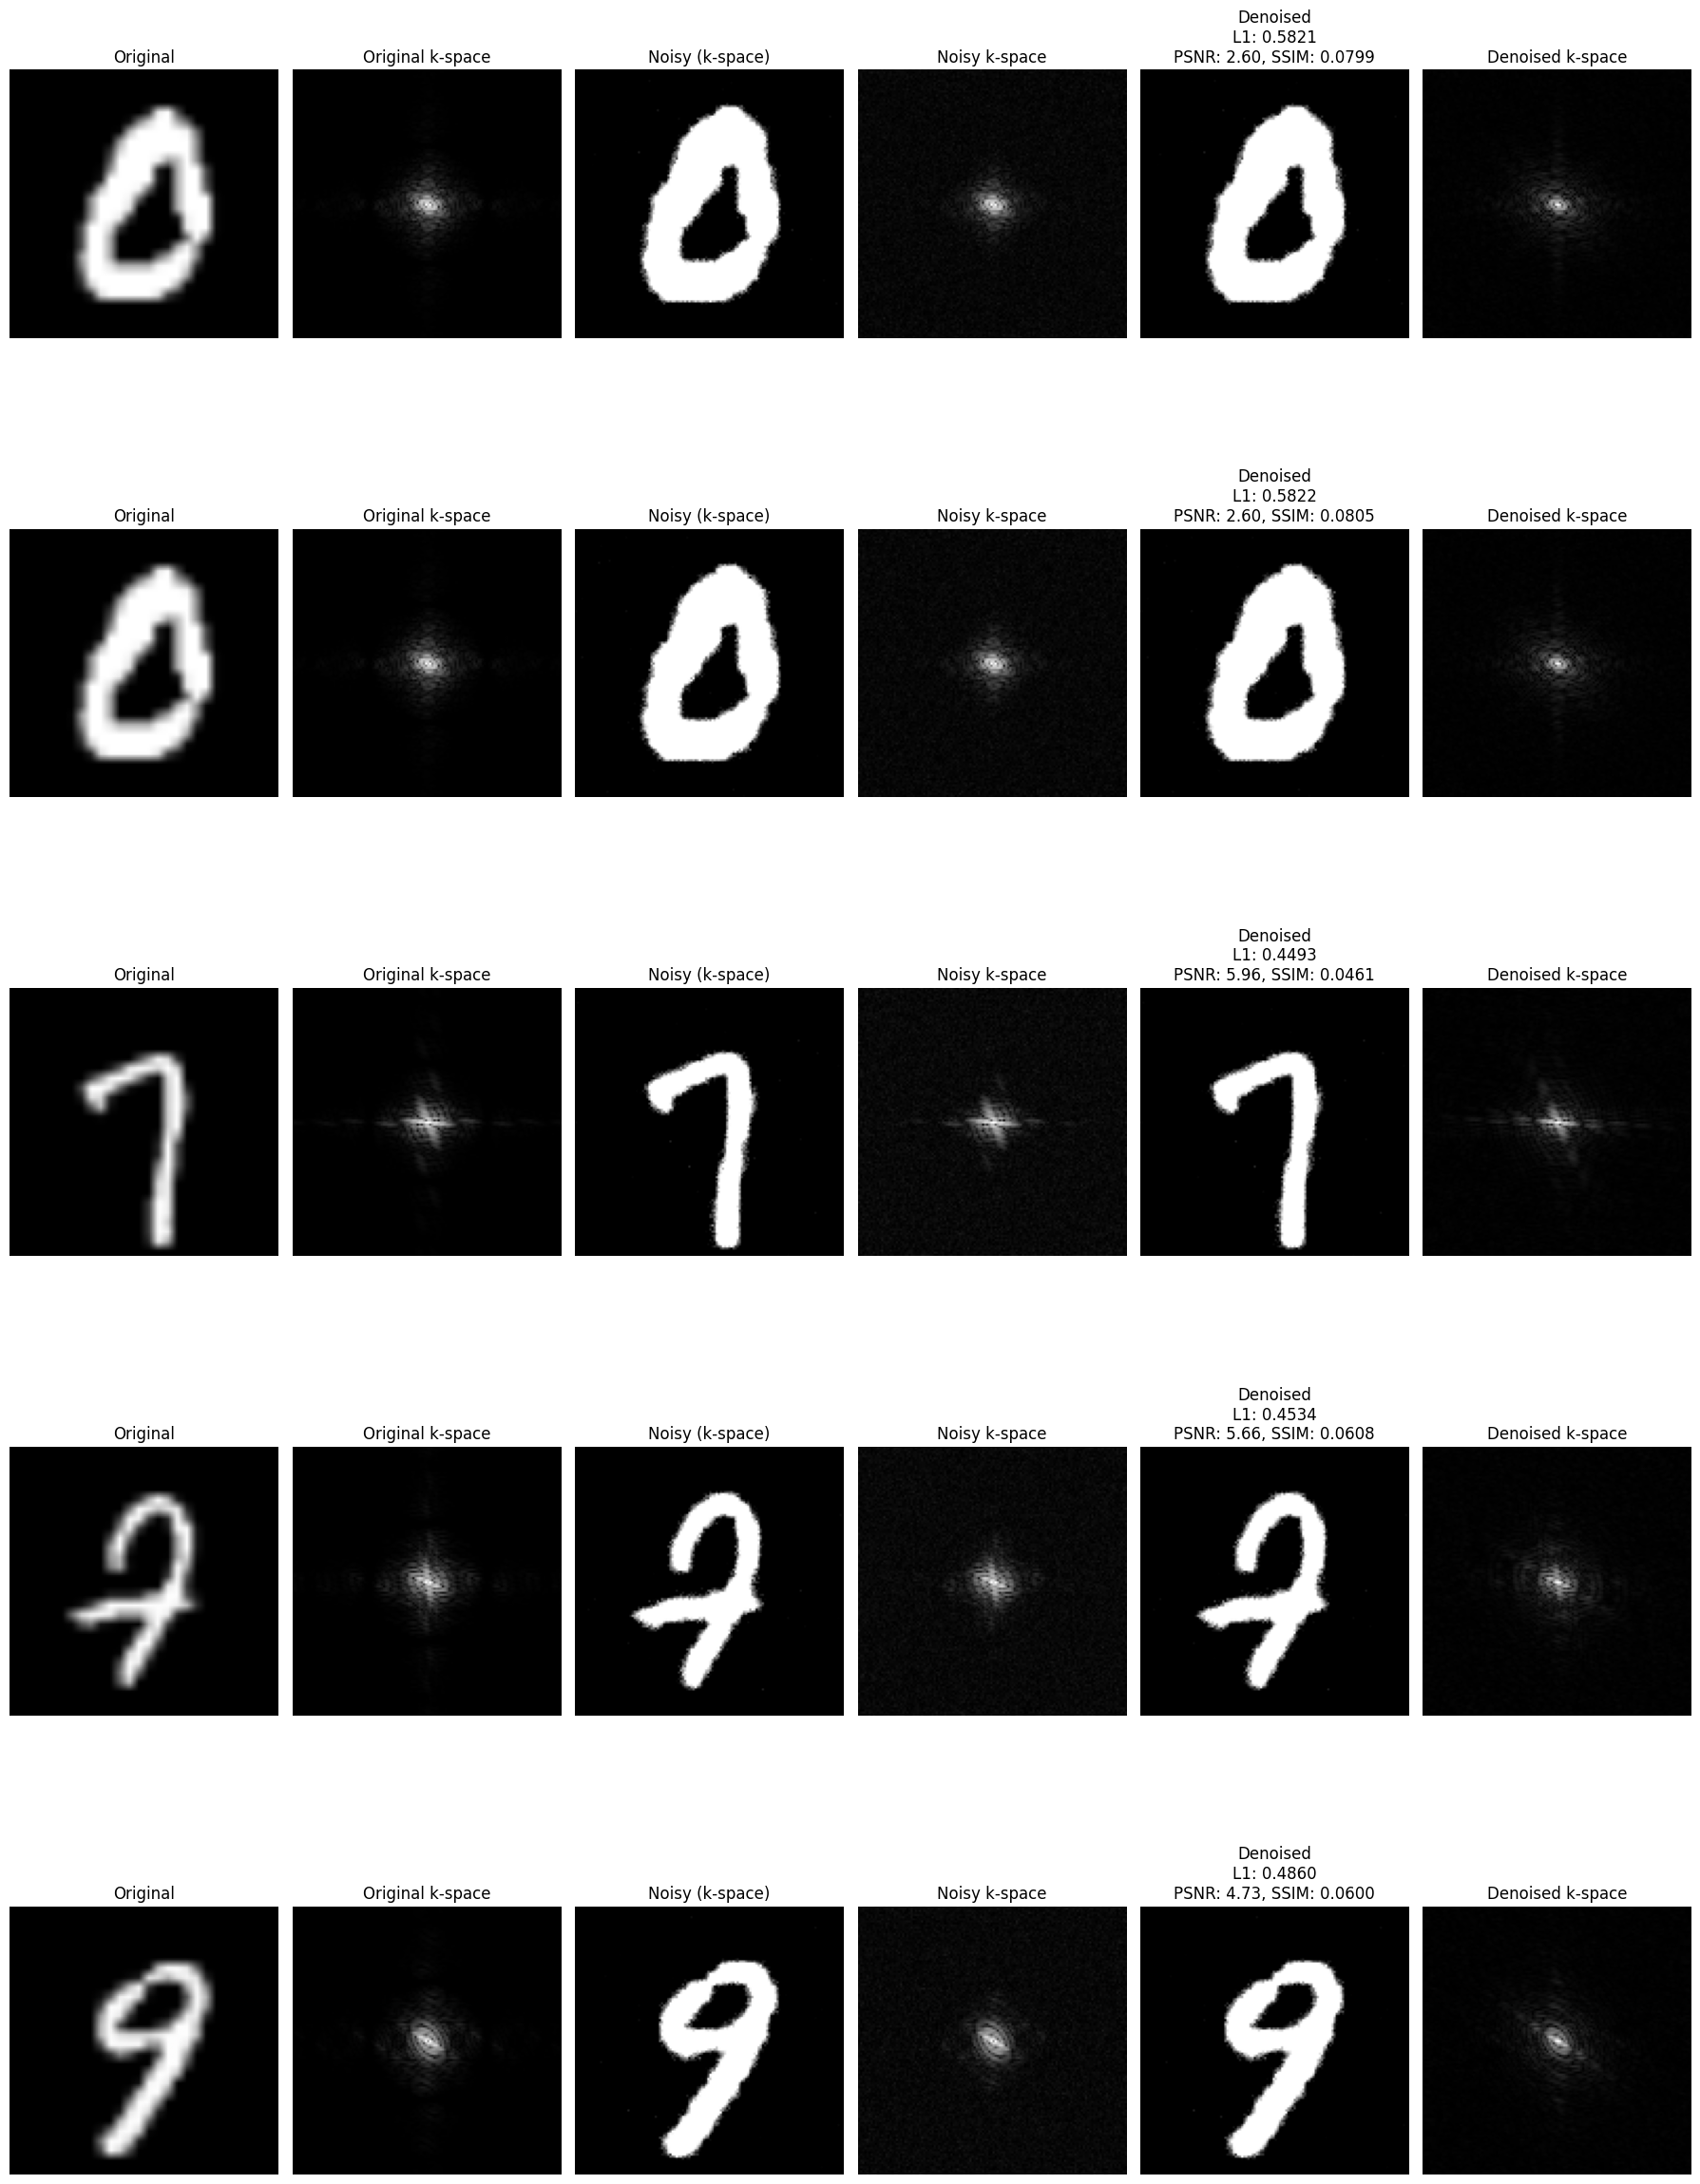

In [20]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

def fft2c(x: torch.Tensor) -> torch.Tensor:
    """Centered 2D FFT"""
    x = x.to(torch.complex64)
    x = torch.fft.ifftshift(x, dim=(-2, -1))
    k = torch.fft.fft2(x, dim=(-2, -1), norm="ortho")
    return torch.fft.fftshift(k, dim=(-2, -1))

def kspace_logmag(k: torch.Tensor) -> torch.Tensor:
    """Log-magnitude normalized to [0,1] for display"""
    mag = torch.log1p(k.abs())
    m = mag.amin(dim=(-2, -1), keepdim=True)
    M = mag.amax(dim=(-2, -1), keepdim=True)
    return ((mag - m) / (M - m + 1e-8)).clamp(0, 1)

# ---- visualization ----
batch = next(iter(val_loader))
if isinstance(batch, (list, tuple)):
    batch = batch[0]
vd = batch.to(device)

random_indices = torch.randint(0, vd.size(0), (5,))
plt.figure(figsize=(18, 25))

with torch.no_grad():
    for i, idx in enumerate(random_indices):
        xv = vd[idx].unsqueeze(0)  # (1,1,H,W)

        # Original k-space
        k_clean = fft2c(xv)

        # Add noise in k-space
        xv_noisy, _ = add_gaussian_noise_kspace(xv, max_sigma=0.2, min_sigma=0.2)
        k_noisy = fft2c(xv_noisy)

        # Denoise
        pred_noise = unet(xv_noisy)
        pred = (xv_noisy - pred_noise).clamp(0, 1)
        k_pred = fft2c(pred)

        # --- Plotting ---
        plt.subplot(5, 6, i * 6 + 1)
        plt.imshow(xv.cpu().squeeze(), cmap="gray")
        plt.title("Original")
        plt.axis("off")

        plt.subplot(5, 6, i * 6 + 2)
        plt.imshow(kspace_logmag(k_clean).cpu().squeeze(), cmap="gray")
        plt.title("Original k-space")
        plt.axis("off")

        plt.subplot(5, 6, i * 6 + 3)
        plt.imshow(xv_noisy.clamp(0, 1).cpu().squeeze(), cmap="gray")
        plt.title("Noisy (k-space)")
        plt.axis("off")

        plt.subplot(5, 6, i * 6 + 4)
        plt.imshow(kspace_logmag(k_noisy).cpu().squeeze(), cmap="gray")
        plt.title("Noisy k-space")
        plt.axis("off")

        plt.subplot(5, 6, i * 6 + 5)
        plt.imshow(pred.cpu().squeeze(), cmap="gray")
        plt.title(
            f"Denoised\n"
            f"L1: {F.l1_loss(pred, xv).item():.4f}\n"
            f"PSNR: {compute_psnr(xv.squeeze(), pred.squeeze()):.2f}, "
            f"SSIM: {compute_ssim(xv.squeeze(), pred.squeeze()):.4f}"
        )
        plt.axis("off")

        plt.subplot(5, 6, i * 6 + 6)
        plt.imshow(kspace_logmag(k_pred).cpu().squeeze(), cmap="gray")
        plt.title("Denoised k-space")
        plt.axis("off")

plt.tight_layout()
plt.show()
